In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml
import numpy as np
import pandas as pd

 - Take correlation of u-error vs u-current (same for v)
 - Is there a correlation?
 - Is it strong enough to exploit?

In [9]:
data_dir = "../../../data/drifter_data/dataset_forecast_error/area1_big"
files = os.listdir(data_dir)
df = pd.DataFrame()
for file in files:
    df = pd.concat([df, pd.read_csv(os.path.join(data_dir, file))], ignore_index=True)
df

2


,time,lon,lat,u,v,buoy,file_name,u_forecast,v_forecast,u_error,v_error
0,2022-05-06 23:00:00,-141.774,36.250,-0.371,0.199,2101600,GL_TS_DC_2101600_202205,0.044497,-0.183604,0.415497,-0.382604
1,2022-05-07 00:00:00,-141.766,36.238,-0.386,0.212,2101600,GL_TS_DC_2101600_202205,0.049785,-0.176304,0.435785,-0.388304
2,2022-05-07 01:00:00,-141.757,36.226,-0.402,0.212,2101600,GL_TS_DC_2101600_202205,0.066003,-0.174072,0.468003,-0.386072
3,2022-05-07 02:00:00,-141.748,36.212,-0.432,0.187,2101600,GL_TS_DC_2101600_202205,0.091644,-0.171829,0.523644,-0.358829
4,2022-05-07 03:00:00,-141.742,36.198,-0.463,0.149,2101600,GL_TS_DC_2101600_202205,0.110934,-0.179170,0.573934,-0.328170
...,...,...,...,...,...,...,...,...,...,...,...
23172,2022-05-11 20:00:00,-137.569,28.235,-0.046,-0.259,5501571,GL_TS_DC_5501571_202205,-0.195436,0.088748,-0.149436,0.347748
23173,2022-05-11 21:00:00,-137.576,28.233,-0.046,-0.217,5501571,GL_TS_DC_5501571_202205,-0.195201,0.085234,-0.149201,0.302234
23174,2022-05-11 22:00:00,-137.585,28.232,-0.031,-0.190,5501571,GL_TS_DC_5501571_202205,-0.196895,0.084155,-0.165895,0.274155
23175,2022-05-11 23:00:00,-137.591,28.231,-0.017,-0.190,5501571,GL_TS_DC_5501571_202205,-0.200496,0.084123,-0.183496,0.274123


In [20]:
u_mat = np.vstack([df["u_error"], df["u_forecast"]])
v_mat = np.vstack([df["v_error"], df["v_forecast"]])

u_mean = np.mean(np.vstack([df["u_error"], df["u_forecast"]]), axis=1)
v_mean = np.mean(np.vstack([df["v_error"], df["v_forecast"]]), axis=1)

# subtracting the mean and finding correlation
u_corr = np.corrcoef(u_mat - u_mean.reshape(-1,1))
v_corr = np.corrcoef(v_mat - v_mean.reshape(-1,1))

u_cov = np.cov(u_mat - u_mean.reshape(-1,1))
v_cov = np.cov(v_mat - v_mean.reshape(-1,1))

print(u_corr)
print(v_corr)

print(u_cov)
print(v_cov)

[[1.         0.71721437]
 [0.71721437 1.        ]]
[[1.         0.65221859]
 [0.65221859 1.        ]]
[[0.0315234  0.01287754]
 [0.01287754 0.01022667]]
[[0.02652268 0.01118087]
 [0.01118087 0.01108019]]


## Using ExperimentRunner class

In [1]:
%load_ext autoreload
%autoreload 2

from ExperimentRunner import ExperimentRunner

import os
import datetime
import dateutil
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple
import numpy as np

# init experiment runner class
ex_runner = ExperimentRunner()
# ex_runner.get_noise()

...Loading info from: index_platform.txt
...Loading info from: index_latest.txt
...Loading info from: index_monthly.txt
...Loading info from: index_history.txt
Num of buoys in spatio-temporal range: 94
Forecast is the same as Hindcast for OceanCurrents.


100%|██████████| 706/706 [00:04<00:00, 145.25it/s]

Percentage of failed interp: 0.0%


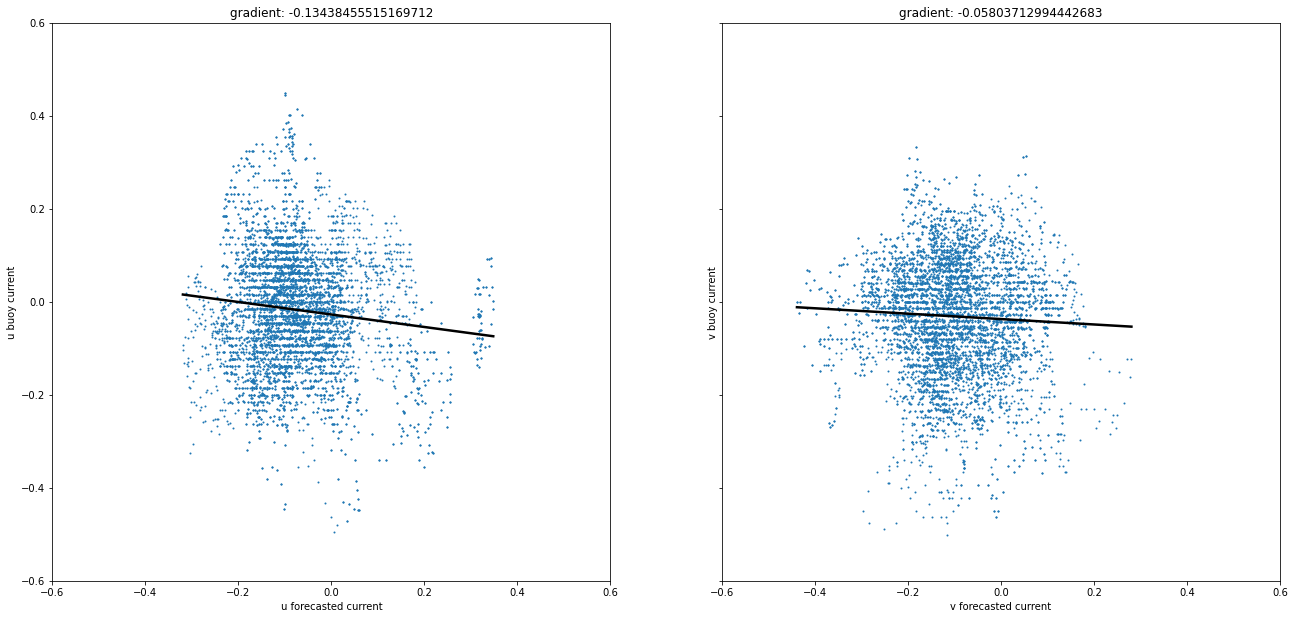

In [8]:
def setup_subplots(rows:int, cols:int, size:Tuple[int], x_range:Tuple[float], y_range:Tuple[float]):
    fig, axs = plt.subplots(rows,cols, figsize=size, sharex=True, sharey=True)
    for ax in range(rows*cols):
        axs[ax].set(adjustable='box', aspect='equal')
    plt.setp(axs, xlim=x_range, ylim=y_range)
    return fig, axs

def plot_line_of_best_fit(x,y, ax):
    b, a = np.polyfit(x, y, deg=1)
    ax.title.set_text(f"gradient: {b}")
    xseq = np.linspace(np.nanmin(x), np.nanmax(x), num=100)
    ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

def plot_corr_mag_error(df, y:str="buoy"):
    u_forecast = df["u_forecast"]
    v_forecast = df["v_forecast"]

    if y == "buoy":
        u_error = df["u"]
        v_error = df["v"]
        
    elif y == "error":
        u_error = df["u_forecast"] - df["u"]
        v_error = df["v_forecast"] - df["v"]

    fig, axs = setup_subplots(1,2, (22,14), (min(min(u_forecast),min(v_forecast)), max(max(u_forecast), max(v_forecast))), \
        (min(min(u_error), min(v_error)), max(max(u_error), max(v_error))))
    plt.setp(axs, xlim=(-0.6,0.6), ylim=(-0.6,0.6))
    axs[0].scatter(u_forecast, u_error, s=1)
    # Print the regression line
    plot_line_of_best_fit(u_forecast, u_error, axs[0])
    plot_line_of_best_fit(v_forecast, v_error, axs[1])
    axs[1].scatter(v_forecast, v_error, s=1)
    axs[0].set_xlabel("u forecasted current")
    axs[0].set_ylabel(f"u {y} current")
    axs[1].set_xlabel("v forecasted current")
    axs[1].set_ylabel(f"v {y} current")
    plt.savefig("/home/jonas/Downloads/corr.png", bbox_inches='tight')
    plt.show()

plot_corr_mag_error(ex_runner.data, y="buoy")

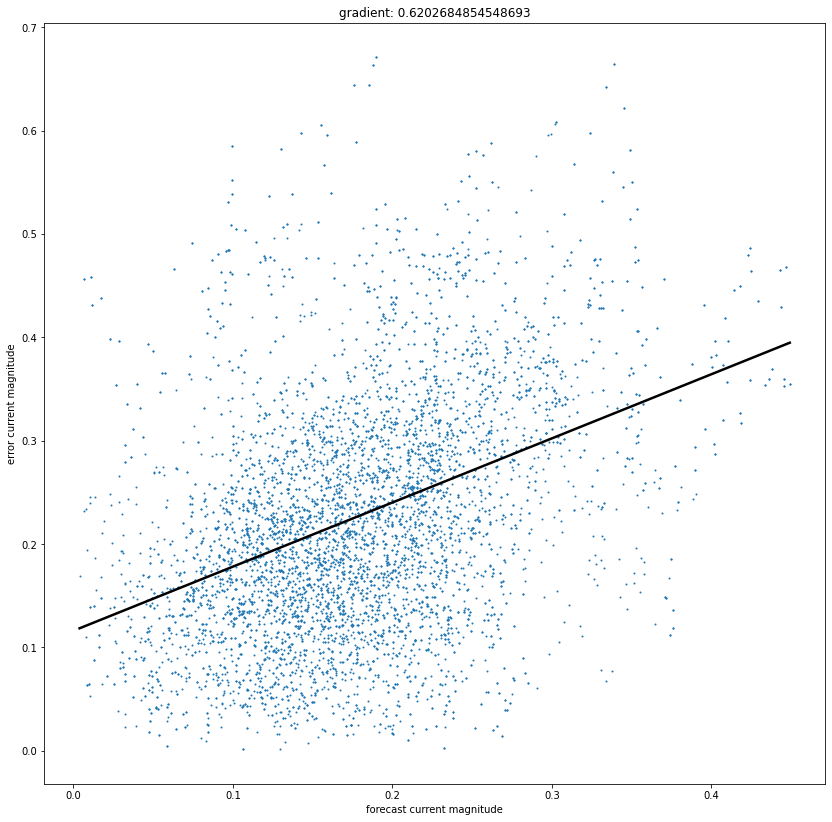

In [27]:
def plot_corr_mag_error(df, y:str="buoy"):
    u_forecast = df["u_forecast"]
    v_forecast = df["v_forecast"]
    forecast = np.sqrt(u_forecast**2 + v_forecast**2)

    if y == "buoy":
        u_error = df["u"]
        v_error = df["v"]
        error = np.sqrt(u_error**2 + v_error**2)
        
    elif y == "error":
        u_error = df["u_forecast"] - df["u"]
        v_error = df["v_forecast"] - df["v"]
        error = np.sqrt(u_error**2 + v_error**2)

    fig = plt.figure(figsize=(14,14))
    plt.scatter(forecast, error, s=1)
    b, a = np.polyfit(forecast, error, deg=1)
    plt.title(f"gradient: {b}")
    xseq = np.linspace(np.nanmin(forecast), np.nanmax(forecast), num=100)
    plt.plot(xseq, a + b * xseq, color="k", lw=2.5)
    # Print the regression line
    # plot_line_of_best_fit(u_forecast, u_error, fig)
    # plot_line_of_best_fit(v_forecast, v_error, fig)
    plt.xlabel("forecast current magnitude")
    plt.ylabel(f"{y} current magnitude")
    # plt.xlim(-0.6, 0.6)
    # plt.ylim(-0.6,0.6)
    plt.savefig("/home/jonas/Downloads/corr_mag.png", bbox_inches='tight')
    plt.show()

plot_corr_mag_error(ex_runner.data, y="error")

Switching between "buoy" and "error" for the y-parameter:
 - error vs forecast has to be correlated since the error contains the forecast (error = forecast - buoy), given the buoy value does not dominate (which it does not).
 - buoy vs forecast shows no correlation at all.

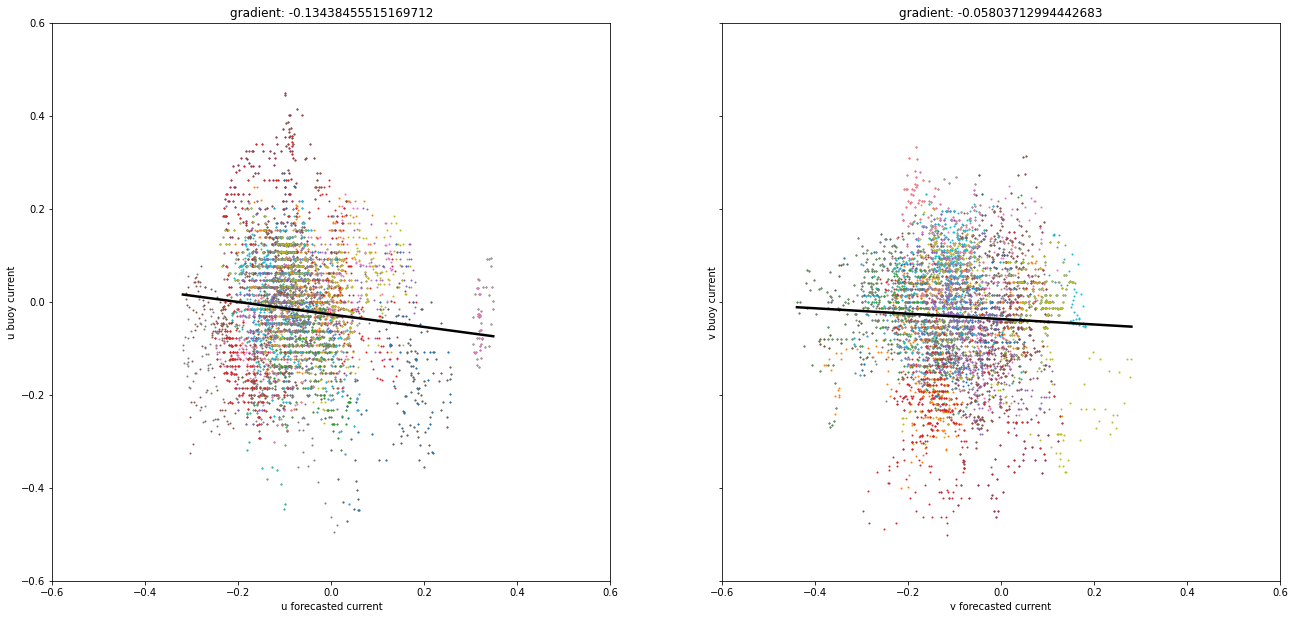

In [12]:
def plot_corr_mag_error_colour_coded_buoys(df, y:str="buoy"):
    buoy_names = set(df["buoy"].to_list())
    fig, axs = plt.subplots(1, 2, figsize=(22,14), sharex=True, sharey=True)
    plt.setp(axs, xlim=(-0.6,0.6), ylim=(-0.6,0.6))
    for buoy_name in buoy_names:
        u_forecast = df[df["buoy"] == buoy_name]["u_forecast"]
        v_forecast = df[df["buoy"] == buoy_name]["v_forecast"]

        if y == "buoy":
            u_error = df[df["buoy"] == buoy_name]["u"]
            v_error = df[df["buoy"] == buoy_name]["v"]
        elif y == "error":
            u_error = df[df["buoy"] == buoy_name]["u_forecast"] - df[df["buoy"] == buoy_name]["u"]
            v_error = df[df["buoy"] == buoy_name]["v_forecast"] - df[df["buoy"] == buoy_name]["v"]

        axs[0].scatter(u_forecast, u_error, s=1)
        axs[1].scatter(v_forecast, v_error, s=1)
        axs[0].set_xlabel("u forecasted current")
        axs[0].set_ylabel(f"u {y} current")
        axs[0].set(adjustable='box', aspect='equal')
        axs[1].set_xlabel("v forecasted current")
        axs[1].set_ylabel(f"v {y} current")
        axs[1].set(adjustable='box', aspect='equal')

    # Print the regression line
    u_forecast = df["u_forecast"]
    v_forecast = df["v_forecast"]

    if y == "buoy":
        u_error = df["u"]
        v_error = df["v"]
    elif y == "error":
        u_error = df["u_forecast"] - df["u"]
        v_error = df["v_forecast"] - df["v"]
    plot_line_of_best_fit(u_forecast, u_error, axs[0])
    plot_line_of_best_fit(v_forecast, v_error, axs[1])
    plt.savefig("/home/jonas/Downloads/corr_buoy_colored.png", bbox_inches='tight')
    plt.show()

plot_corr_mag_error_colour_coded_buoys(ex_runner.data, y="buoy")

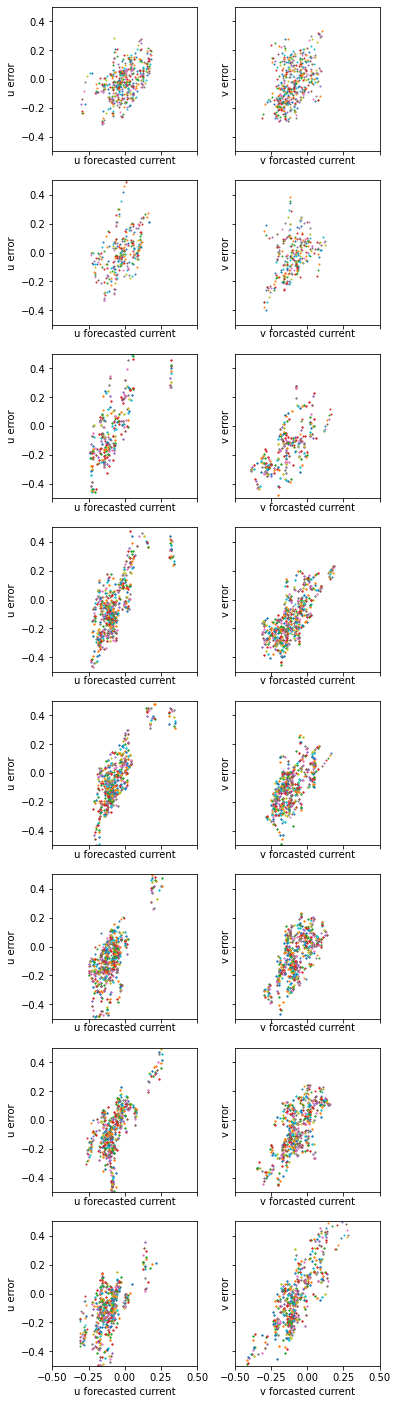

In [5]:
def plot_corr_mag_error_per_day_colour(df, y:str="buoy"):
    # plotting daily correlation between error and forecasted current with each hour being a different colour

    df["day"] = df["time"].apply(lambda x: x.day)
    days = sorted(set(df["day"].tolist()))
    df["hour"] = df["time"].apply(lambda x: x.hour)
    hours = sorted(set(df["hour"].tolist()))

    fig, axs = plt.subplots(len(days)-2,2, figsize=(6,25), sharex=True, sharey=True)
    plt.setp(axs, xlim=(-0.5,0.5), ylim=(-0.5,0.5))

    for i, day in enumerate(days[1:-1]):
        for hour in hours:
            u_forecast = df[(df["day"] == day) & (df["hour"] == hour)]["u_forecast"]
            v_forecast = df[(df["day"] == day) & (df["hour"] == hour)]["v_forecast"]

            if y == "buoy":
                u_error = df[(df["day"] == day) & (df["hour"] == hour)]["u"]
                v_error = df[(df["day"] == day) & (df["hour"] == hour)]["v"]

            elif y == "error":
                v_error = df[(df["day"] == day) & (df["hour"] == hour)]["v_forecast"] \
                    - df[(df["day"] == day) & (df["hour"] == hour)]["v"]
                u_error = df[(df["day"] == day) & (df["hour"] == hour)]["u_forecast"] \
                    - df[(df["day"] == day) & (df["hour"] == hour)]["u"]

            axs[i,0].scatter(u_forecast, u_error, s=1)
            axs[i,1].scatter(v_forecast, v_error, s=1)
            axs[i,0].set_xlabel("u forecasted current")
            axs[i,0].set_ylabel(f"u {y}")
            axs[i,0].set(adjustable='box', aspect='equal')
            axs[i,1].set_xlabel("v forcasted current")
            axs[i,1].set_ylabel(f"v {y}")
            axs[i,1].set(adjustable='box', aspect='equal')
    plt.savefig("/home/jonas/Downloads/corr_per_day_colored_hourly.png", bbox_inches='tight')
    plt.show()

plot_corr_mag_error_per_day_colour(ex_runner.data, y="error")

5499.602182362113 -27640.64703051184


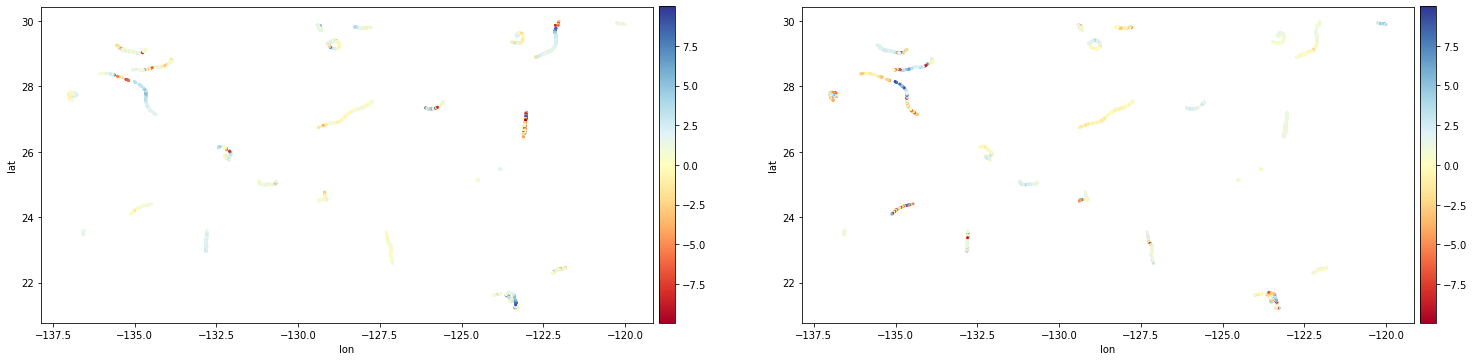

In [6]:
def plot_spatial_relative_error(df):
    #plotting error wrt current velocity

    u_forecast = df["u_forecast"]
    u_error = df["u_forecast"] - df["u"]
    v_forecast = df["v_forecast"]
    v_error = df["v_forecast"] - df["v"]

    df["u_relative_error"] = u_error/u_forecast
    df["v_relative_error"] = v_error/v_forecast

    print(max(df["u_relative_error"]), min(df["u_relative_error"]))

    # define colormap
    cm = plt.cm.get_cmap('RdYlBu')

    # filter outliers
    df = df[(df["u_relative_error"] < 10) & (df["u_relative_error"] > -10)]
    df = df[(df["v_relative_error"] < 10) & (df["v_relative_error"] > -10)]

    fig, axs = plt.subplots(1,2, figsize=(25,16))
    im1 = axs[0].scatter(df["lon"], df["lat"], c=df["u_relative_error"], cmap=cm, s=3)
    axs[0].set(adjustable='box', aspect='equal')
    axs[0].set_xlabel("lon")
    axs[0].set_ylabel("lat")
    im2 = axs[1].scatter(df["lon"], df["lat"], c=df["v_relative_error"], cmap=cm, s=3)
    axs[1].set(adjustable='box', aspect='equal')
    axs[1].set_xlabel("lon")
    axs[1].set_ylabel("lat")
    plt.colorbar(im1, ax=axs[0], fraction=0.025, pad=0.01)
    plt.colorbar(im2, ax=axs[1], fraction=0.025, pad=0.01)
    plt.savefig("/home/jonas/Downloads/spatial_relative_error.png", bbox_inches='tight')
    plt.show()

plot_spatial_relative_error(ex_runner.data)

What if we use gaussian noise (with buoy stats) to calculate the error instead of the actual buoy data?
Is buoy data roughly normal?

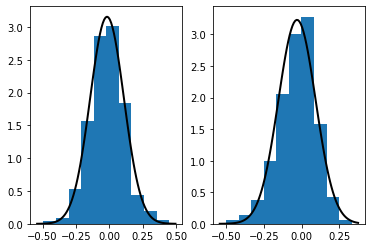

In [7]:
# plot histogram of buoy data
from scipy.stats import norm

df = ex_runner.data

mean_u, std_u = norm.fit(df["u"])
mean_v, std_v = norm.fit(df["v"])

fig, axs = plt.subplots(1,2)
axs[0].hist(df["u"], density=True)
axs[1].hist(df["v"], density=True)

# plot pdf
xmin_u, xmax_u = axs[0].get_xlim()
xmin_v, xmax_v = axs[1].get_xlim()
x_u = np.linspace(xmin_u, xmax_u, 100)
x_v = np.linspace(xmin_v, xmax_v, 100)
pdf_u = norm.pdf(x_u, mean_u, std_u)
pdf_v = norm.pdf(x_v, mean_v, std_v)
axs[0].plot(x_u, pdf_u, 'k', linewidth=2)
axs[1].plot(x_v, pdf_v, "k", linewidth=2)

plt.show()

[-0.13010824  0.02386981  0.02253952 ...  0.21623496 -0.08299376
  0.00704327]


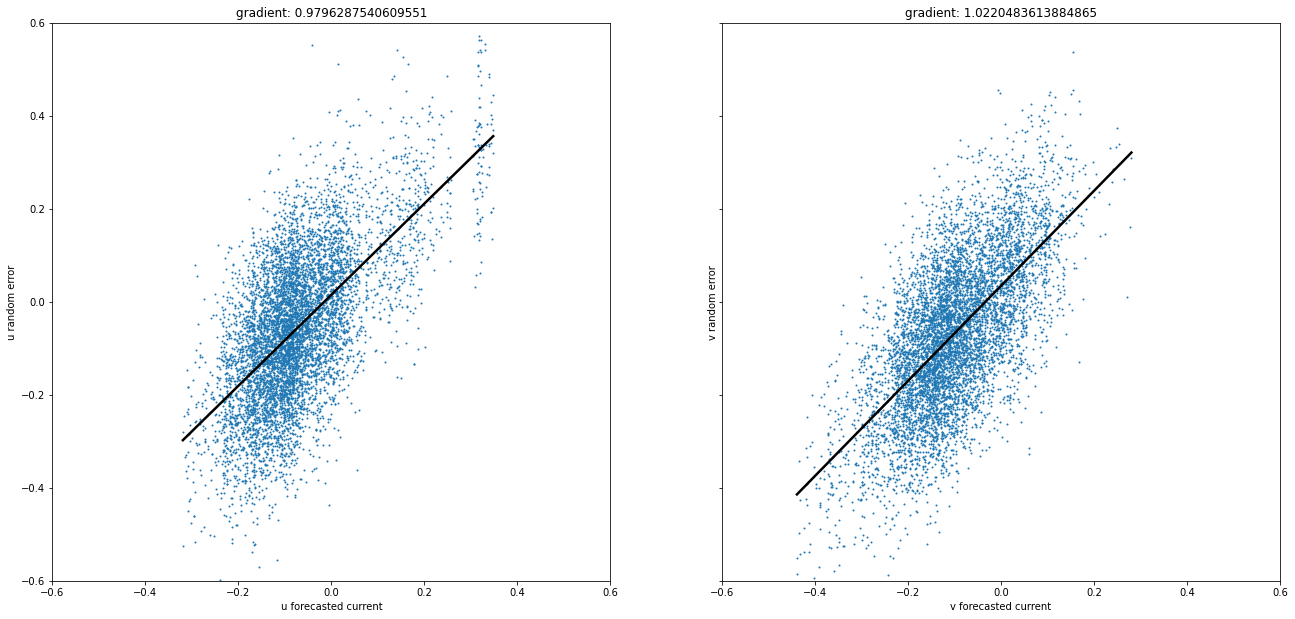

In [8]:
# get mean and variance for buoy data -> create new random buoy data from gaussian
# make same plots

from typing import List

df = ex_runner.data

def sample_from_normal(data: List[float]):
    mean = np.mean(data)
    var = np.var(data)
    out = np.random.normal(mean, np.sqrt(var), size=len(data))
    return out

new_u = sample_from_normal(df["u"].tolist())
new_v = sample_from_normal(df["v"].tolist())

u_forecast = df["u_forecast"]
u_error = df["u_forecast"] - new_u
v_forecast = df["v_forecast"]
v_error = df["v_forecast"] - new_v

fig, axs = setup_subplots(1,2, (22,14), (min(min(u_forecast),min(v_forecast)), max(max(u_forecast), max(v_forecast))), \
    (min(min(u_error), min(v_error)), max(max(u_error), max(v_error))))
plt.setp(axs, xlim=(-0.6,0.6), ylim=(-0.6,0.6))
axs[0].scatter(u_forecast, u_error, s=1)
# Print the regression line
plot_line_of_best_fit(u_forecast, u_error, axs[0])
plot_line_of_best_fit(v_forecast, v_error, axs[1])
axs[1].scatter(v_forecast, v_error, s=1)
axs[0].set_xlabel("u forecasted current")
axs[0].set_ylabel("u random error")
axs[1].set_xlabel("v forecasted current")
axs[1].set_ylabel("v random error")
plt.savefig("/home/jonas/Downloads/corr_random.png", bbox_inches='tight')
plt.show()

## Plot for GoM